In [2]:
import torch
from torch import nn
from torch.optim import Adam, SGD
from torchsummary import summary
from torch.autograd  import Variable
from torch import nn
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('data_akbilgic.csv')

df_train = df[:400]  # train split, you can use this method to split your data, #hardcoded for now,you can change it
df_test = df[400:] # the most important point is that the latest data is being used for testing


# Receives the number of samples (batch_size) of size (n_steps) to extract from the time series and output a sample

In [4]:
def next_stock_batch(batch_size, n_steps, df_base):
    
    #what would be the relation of x and y: y is of the same size as x, but shifted one period ahead
    
    t_min = 0
    t_max = df_base.shape[0] 
    
    x = np.zeros((batch_size, n_steps, 7))  # 7 columns for the 7 features
    y = np.zeros((batch_size, n_steps, 1))
    
    starting_points = np.random.randint(t_min, t_max - n_steps - 1, size=batch_size) #randomly choose starting points e.g. 14 therfore it is upto 23 if 
    #the steps are 10 
    # online training, you can use this method to generate the starting points, there are no epochs, 
    # an epoch you go through the entire dataset once
    # re-ordeirng the data with epochs -> SGD
    # if we go through the same order -> GD
    # online training, no epochs, radomly choose starting points, 
    # the batches are selected randomly from the data set but the sequence is the same
    # when should you choose epochs and online training? you should use it when the data is stochastic in nature 
    # 

    #how many sequences do we need? depends on the batch_size
    
    for k in range(batch_size):

        lmat = []
        for j in np.arange(n_steps+1):   # here is where the y shift is taking place
            lmat.append(df_base.iloc[starting_points[k]+j,2:].values)
            # appending the intial values to the list, n.b. the value would be +2 on the csv
        
        lmat = np.array(lmat)  # a sequence
        
        x[k,:,:] = lmat[:n_steps,1:]  # the first column is the target, the rest are the inputs
        y[k,:,0] = lmat[1:n_steps+1,0]  # show on the csv
        
        
    return x, y

x,y = next_stock_batch(3, 10, df_train)

print(x.shape)
print(y.shape)


(3, 10, 7)
(3, 10, 1)


In [14]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers):
        super(Model, self).__init__()
        
        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        #Defining the layers
        # RNN Layer
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)  #batch first returns a different shape structure (b,s,..)
        
        # Fully connected layer
        self.fc = nn.Linear(40 * hidden_dim, 40 * hidden_dim) #batch_size * hidden_dim
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        batch_size = x.size(0)
        
        #intializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)
        
        # print(batch_size.shape)
        # print(x.shape)
        # print(hidden.shape)
        
        #Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        hidden_last = hidden[-1]
        out = self.relu(hidden_last.flatten())  #Reshaping the outputs such that it can be fit into the fully connected layer
        
        out = self.fc(out)
        
        return out
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden 
    

In [19]:
n_steps = 40 
n_inputs = 7
n_neurons = 100
hidden_dim = n_steps
n_outputs = 1
learning_rate = 0.01
batch_size = 40



In [20]:
model = Model(n_inputs, n_neurons,  n_steps)

In [21]:
criterion = torch.nn.L1Loss()
optim = Adam(model.parameters(), lr=learning_rate)

In [22]:
# train_losses = []
# #number of batches we will go through
# n_iterations = 500

# #after how many operations we will print information
# printing_gap = 1

# for iter in range(n_iterations):
#     #get a batch
#     x_batch, y_batch = next_stock_batch(batch_size, n_steps, df_train)
    
#     #make to tensors
#     x_batch = torch.from_numpy(x_batch)
#     y_batch = torch.from_numpy(y_batch).squeeze(-1) #squeeze removes the last dimension (40,40) instead of (40,40,1)
    
#     # torch variables
#     x_batch = Variable(x_batch).float()
#     y_batch = Variable(y_batch).float()
    
#     #reset the gradients
#     optim.zero_grad()
    
#     #outputs
#     print(x_batch.shape)
#     print(y_batch.shape)
#     output = model(x_batch)
    
#     #loss
#     loss = criterion(output, y_batch.flatten()) 
    
#     #compute gradients
#     loss.backward()
    
#     #apply the gradients
#     optim.step() 
    
#     #append loss
#     train_losses.append(loss.item())
    
#     if iter % printing_gap == 0:
#         print("iter: ", iter, "\tloss: ", loss.item())

# plt.plot(train_losses, label = "Train Loss")
# plt.xlabel("Iterations")
# plt.ylabel("Loss")
# plt.legend(loc = "best")
# plt.show()
    

torch.Size([40, 40, 7])
torch.Size([40, 40])


RuntimeError: The size of tensor a (4000) must match the size of tensor b (1600) at non-singleton dimension 0

In [26]:
# We initialize our RNN model to pass it to the optimizer
hidden_dim = n_steps
learning_rate = 0.01
batch_size = 40

model = Model(n_inputs, hidden_dim, n_neurons)

# What would be an adequate loss function?
# criterion = torch.nn.NNNLoss()
# criterion = torch.nn.MSELoss()
criterion = torch.nn.L1Loss()

# optimizer to apply the gradients
optim = Adam(model.parameters(), lr=learning_rate)

iter:  0 	Loss:  0.0708136260509491
iter:  1 	Loss:  0.5279101729393005
iter:  2 	Loss:  0.41595008969306946
iter:  3 	Loss:  1.0917264223098755
iter:  4 	Loss:  0.2965041399002075
iter:  5 	Loss:  2.60261607170105
iter:  6 	Loss:  0.22001713514328003
iter:  7 	Loss:  2.434274673461914
iter:  8 	Loss:  0.9138883352279663
iter:  9 	Loss:  2.4702632427215576
iter:  10 	Loss:  1.2285218238830566
iter:  11 	Loss:  0.3187585175037384
iter:  12 	Loss:  0.22580312192440033
iter:  13 	Loss:  0.42612889409065247
iter:  14 	Loss:  0.18171419203281403
iter:  15 	Loss:  0.5959367752075195
iter:  16 	Loss:  0.49722588062286377
iter:  17 	Loss:  0.1498907208442688
iter:  18 	Loss:  0.36135560274124146
iter:  19 	Loss:  0.35662075877189636
iter:  20 	Loss:  0.411380410194397
iter:  21 	Loss:  0.17517462372779846
iter:  22 	Loss:  0.319238543510437
iter:  23 	Loss:  0.44252923130989075
iter:  24 	Loss:  0.40737056732177734
iter:  25 	Loss:  0.2005748301744461
iter:  26 	Loss:  0.26850566267967224
iter

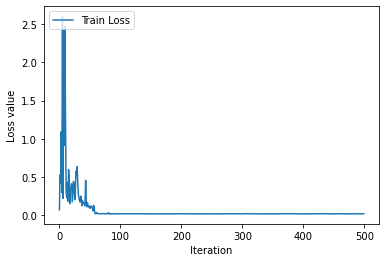

In [27]:
#number of batches we will go through
n_iterations = 500
#how many squence there will be in a bacth
# batch_size = 50
#after how many operations we will print information
printing_gap = 1

#We will store the loss values here to plot them
# train_loss = []

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_loss = []
for iter in range(n_iterations):
    #Get a batch
    x_batch, y_batch = next_stock_batch(batch_size, n_steps, df_train)
    #make into tensor
    x_batch = torch.from_numpy(x_batch)
    y_batch = torch.from_numpy(y_batch).squeeze(-1)
    #make them into torch variables in float format
    x_batch = Variable(x_batch).float()
    y_batch = Variable(y_batch).float()
    #Reset the gradients
    optim.zero_grad()
    #Get the outputs
    # print(x_batch.shape)
    # print(y_batch.shape)
    output = model(x_batch) 
    #compute the loss
    loss = criterion(output, y_batch.flatten())
    #compute the gradients
    loss.backward()
    #Apply the gradients
    optim.step()

    #Append the loss value
    train_loss.append(loss.item())

    if iter % printing_gap == 0:
        #Print the information
        print('iter: ', iter, "\tLoss: ", loss.item())



plt.plot(train_loss, label= "Train Loss")
plt.xlabel(" Iteration ")
plt.ylabel("Loss value")
plt.legend(loc="upper left")
plt.show()